# Differences in the position

In [87]:
import numpy as np
import matplotlib.pyplot as plt
import cv2 as cv
import os

In [88]:
# Get the current working directory
baseFolder = os.getcwd()

# Define the folder containing the images
folder = os.path.join(baseFolder, "photos", "diffDefect")

# Read the image in grayscale
img = cv.imread(os.path.join(folder, "1.png"),0)

print("Image Shape: ", img.shape)
print("Image min: ", img.min())
print("Image max: ", img.max())

img_shown = cv.resize(img, (800, 600))

# The image with the corners is shown
cv.imshow('Loaded Image', img_shown) # We show the found corners in the image
cv.waitKey(100)
cv.destroyAllWindows()

Image Shape:  (1216, 1936)
Image min:  18
Image max:  255


In [89]:
# We load the camera calibration results (We took the photos with the first camera setup)
cameraParameters = np.load(baseFolder + "/calibration/camera_setup1.npz")

# We extract the camera matrix and distortion coefficients, through the keys in the dictionary
mtx = cameraParameters['mtx']
dist = cameraParameters['dist']
res = cameraParameters['res']

(np.float64(-0.5), np.float64(1921.5), np.float64(1201.5), np.float64(-0.5))

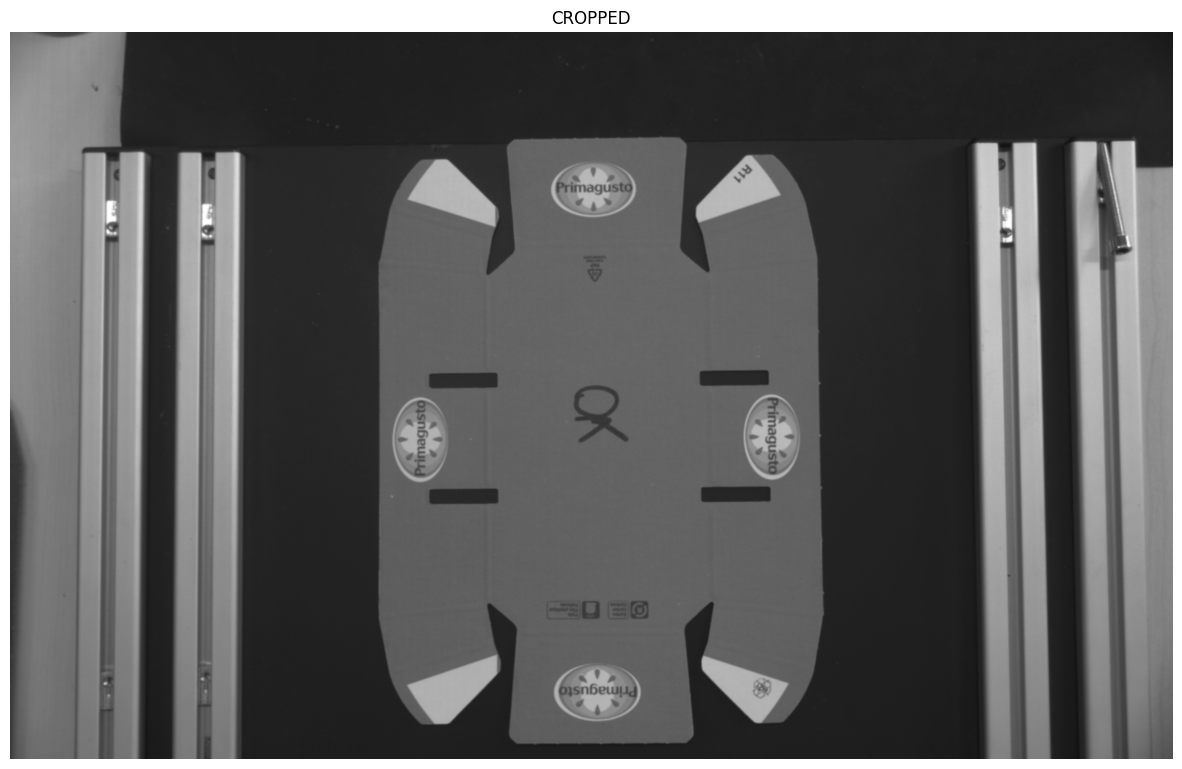

In [90]:
# We find the dimensions of the image
h, w = img.shape[:2]

# We find the new camera matrix and interested region
newcameramtx, roi = cv.getOptimalNewCameraMatrix(mtx, dist, (w,h), 1, (w,h))

# We undistort the image
udst_img = cv.undistort(img, mtx, dist, None, newcameramtx)

# We crop the image using the ROI
x_r, y_r, w_r, h_r = roi
udst_crop_img = udst_img[y_r:y_r+h_r, x_r:x_r+w_r]

img_circle = udst_crop_img.copy()

# We show the croped image
plt.figure(figsize=(15, 10))
plt.imshow(udst_crop_img, cmap="gray", vmin=0, vmax=255)
plt.title("CROPPED")
plt.axis("off")

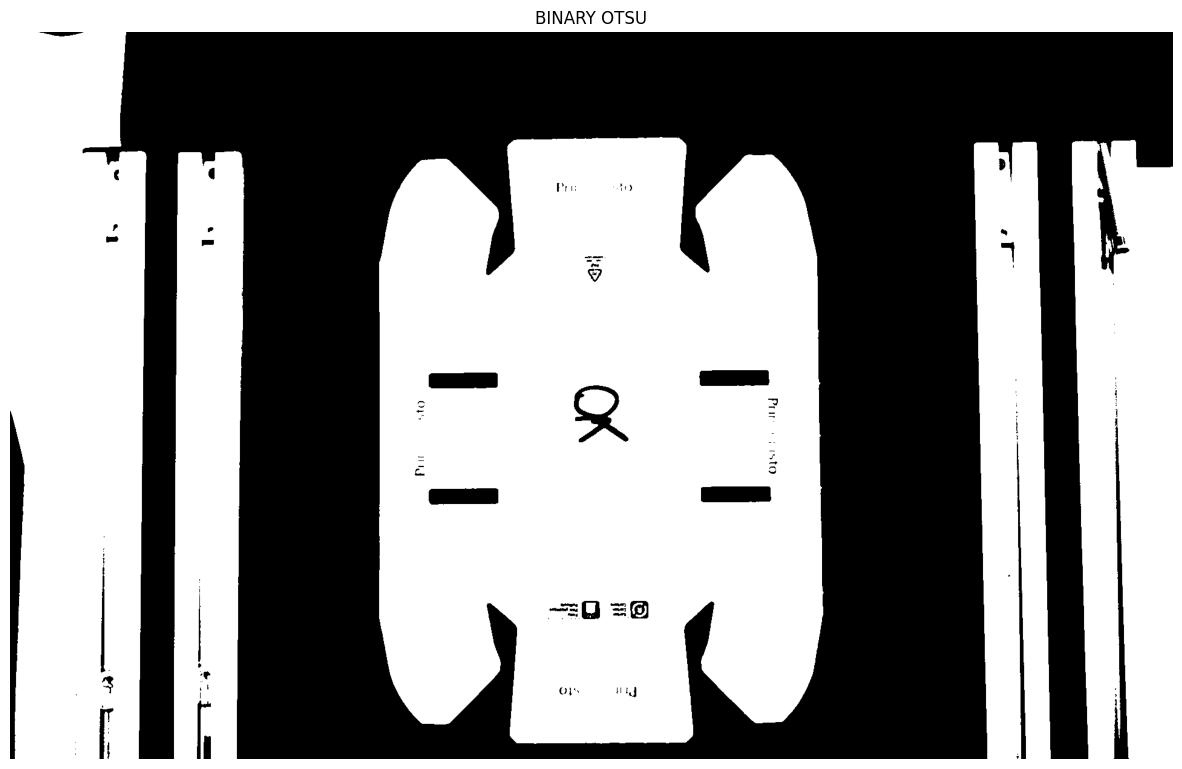

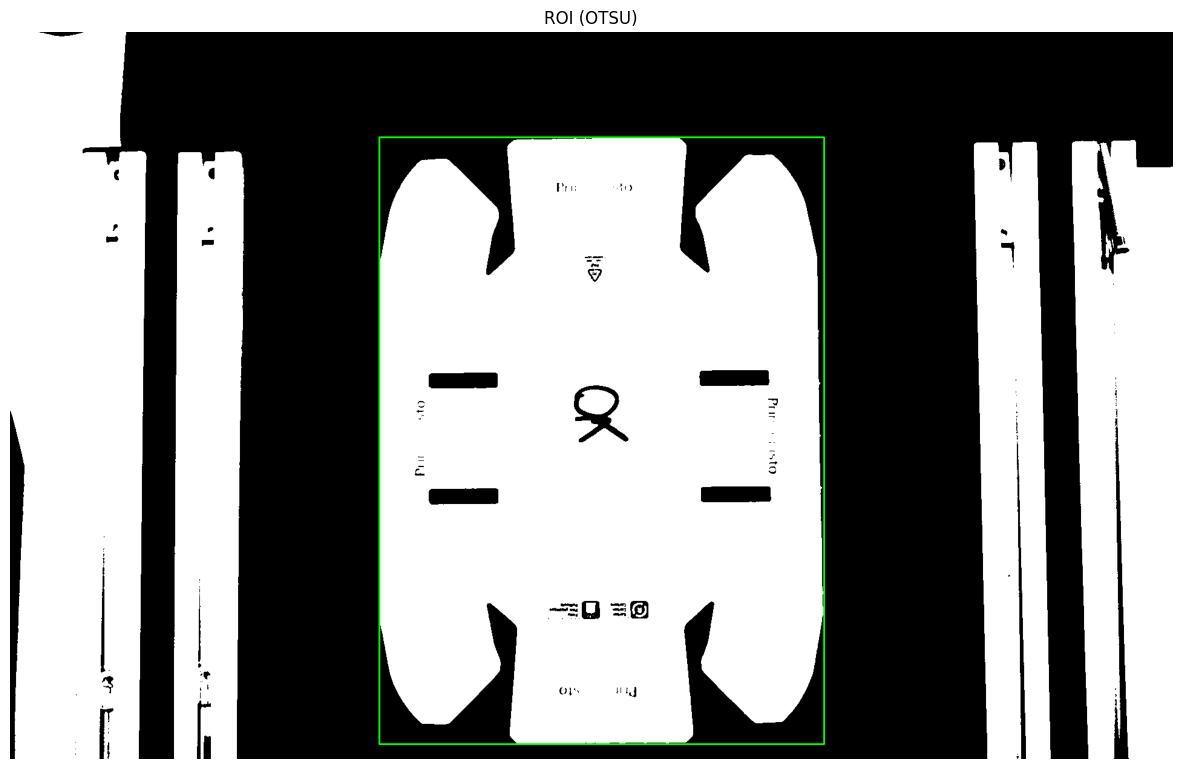

(1202, 1922)


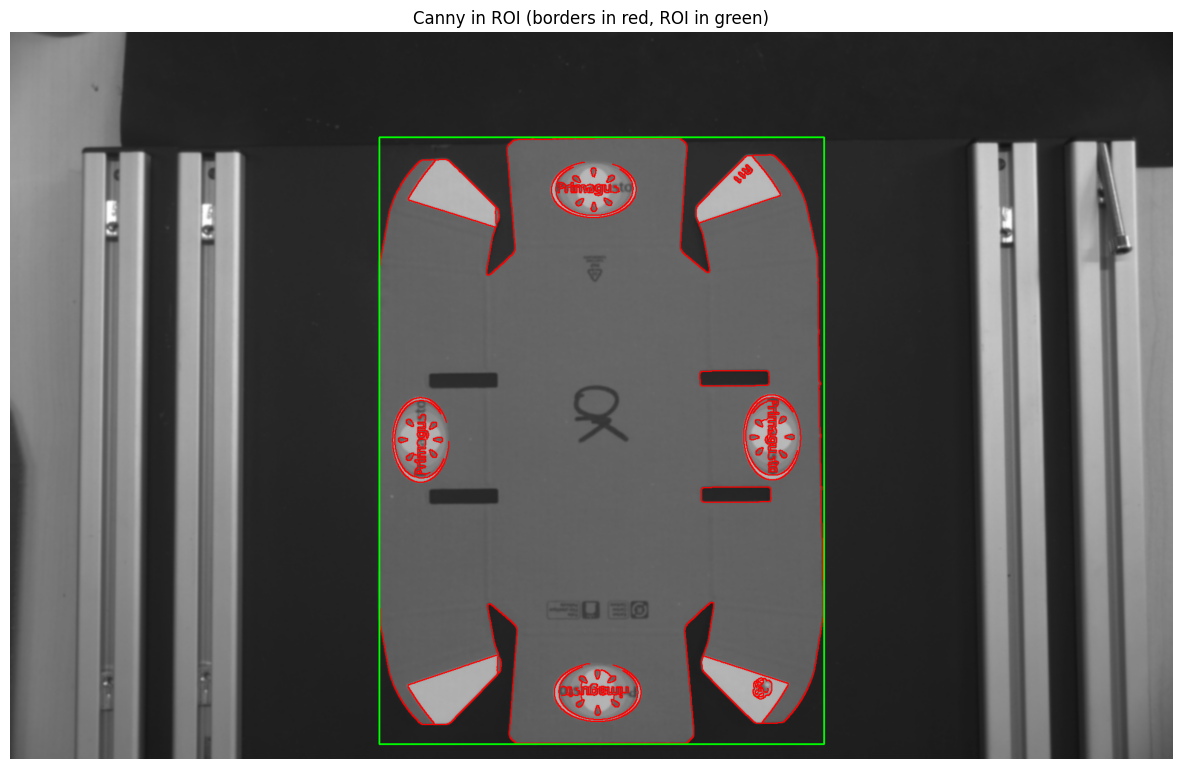

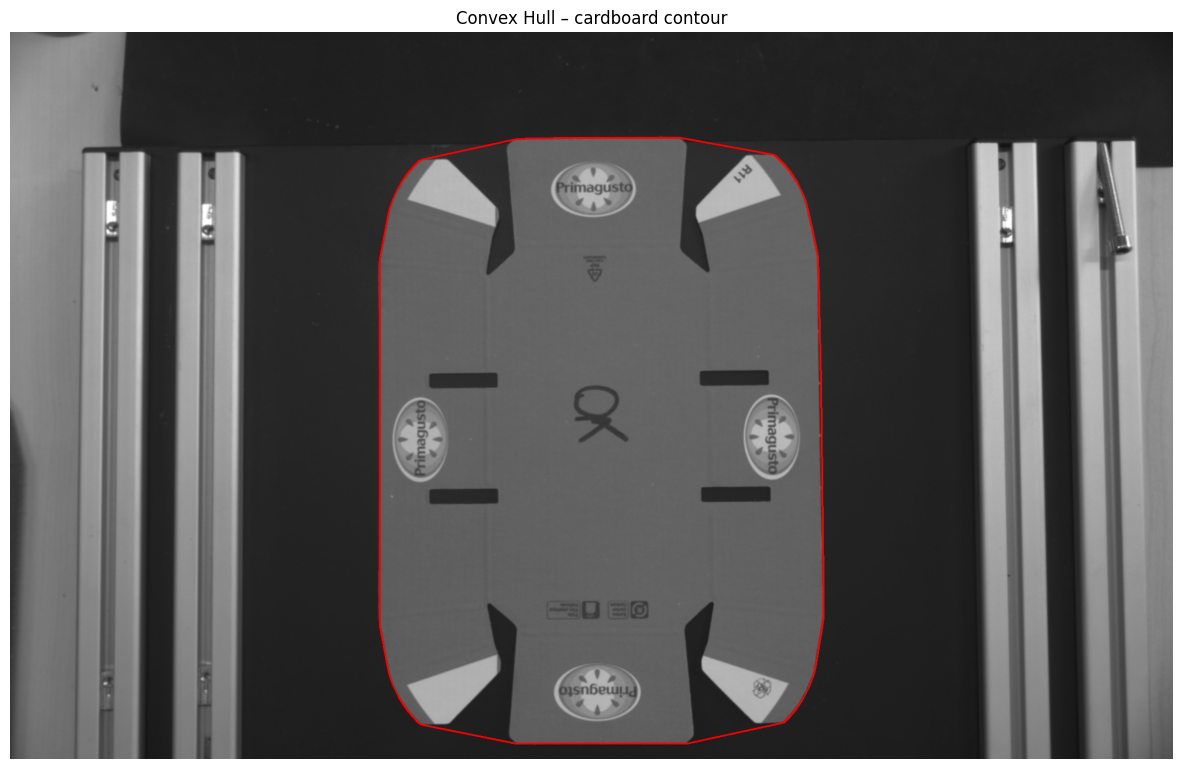

Area of the convex hull:  695158.5


In [91]:
# Thresholding the imnage OTSU gives us the optimal threshold value
_ , th_Bin_OTSU = cv.threshold(udst_crop_img, 0, 255, cv.THRESH_BINARY + cv.THRESH_OTSU)

# Let's see the results
plt.figure(figsize=(15, 10))
plt.imshow(th_Bin_OTSU, cmap="gray", vmin=0, vmax=255) # to complete
plt.title("BINARY OTSU")
plt.axis("off")

# Find the contours in the image
contours, _ = cv.findContours(th_Bin_OTSU, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)

# We search the biggest contour Area Based
contour_max = max(contours, key=cv.contourArea)

# Bounding box of the biggest contour
x, y, w, h = cv.boundingRect(contour_max)

# We expand the ROI
margin = 0  # Additional pixels to the ROI
x_roi = max(x - margin, 0)
y_roi = max(y - margin, 0)
w_roi = min(w + 2 * margin, th_Bin_OTSU.shape[1] - x_roi)
h_roi = min(h + 2 * margin, th_Bin_OTSU.shape[0] - y_roi)

# Draw a green rectangle using BGR
img_with_roi = cv.cvtColor(th_Bin_OTSU, cv.COLOR_GRAY2BGR)
cv.rectangle(img_with_roi, (x_roi, y_roi), (x_roi + w_roi, y_roi + h_roi), (0, 255, 0), 2)

# We show the image with the ROI detected
plt.figure(figsize=(15, 10))
plt.imshow(img_with_roi)
plt.title("ROI (OTSU)")
plt.axis("off")
plt.show()

# We distort the image
blur = cv.GaussianBlur(udst_crop_img, (5, 5), 0)

print(blur.shape)

# We use the ROI found in the previous step
roi = blur[y_roi:y_roi+h_roi, x_roi:x_roi+w_roi]

# We apply the canny on the ROI
canny_edges_roi = cv.Canny(roi, 40, 130, L2gradient=True)
# print("Borders detected:", np.count_nonzero(canny_edges_roi))

# Dilate the edges
kernel = np.ones((2, 2), np.uint8)
canny_edges = cv.dilate(canny_edges_roi, kernel, iterations=1)

# we make a color copy of the image
img_copy = blur.copy()
img_color_copy = cv.cvtColor(img_copy, cv.COLOR_GRAY2BGR)

# We draw the edges in red on the original image
mask = canny_edges > 0

# We draw the edges in red on the original image
roi_color = img_color_copy[y_roi:y_roi+h_roi, x_roi:x_roi+w_roi]
roi_color[mask] = [0, 0, 255] # red (BGR)

# We draw a rectangle of the ROI in green
cv.rectangle(img_color_copy, (x_roi, y_roi), (x_roi + w_roi, y_roi + h_roi), (0, 255, 0), 2)

# The results are shown
plt.figure(figsize=(15, 10))
plt.title("Canny in ROI (borders in red, ROI in green)")
plt.imshow(cv.cvtColor(img_color_copy, cv.COLOR_BGR2RGB))
plt.axis("off")
plt.show()


# We find the contours of the image
contours, _ = cv.findContours(canny_edges, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)

# We only keep the contours with the maximum area
max_contour = max(contours, key=cv.contourArea)

# We calculate the convex hull of the maximum contour
hull = cv.convexHull(max_contour)

# We add the offset of the ROI to the convex hull
hull_offset = hull + np.array([[[x_roi, y_roi]]])

# We draw the convex hull in red color
contour_img = cv.cvtColor(udst_crop_img, cv.COLOR_GRAY2BGR)
cv.drawContours(contour_img, [hull_offset], -1, (0,0,255), 2)

# The results are shown
plt.figure(figsize=(15,10))
plt.title("Convex Hull – cardboard contour")
plt.imshow(cv.cvtColor(contour_img, cv.COLOR_BGR2RGB))
plt.axis("off")
plt.show()

# We calculate the area of the convex hull
area = cv.contourArea(hull_offset)
print("Area of the convex hull: ", area)

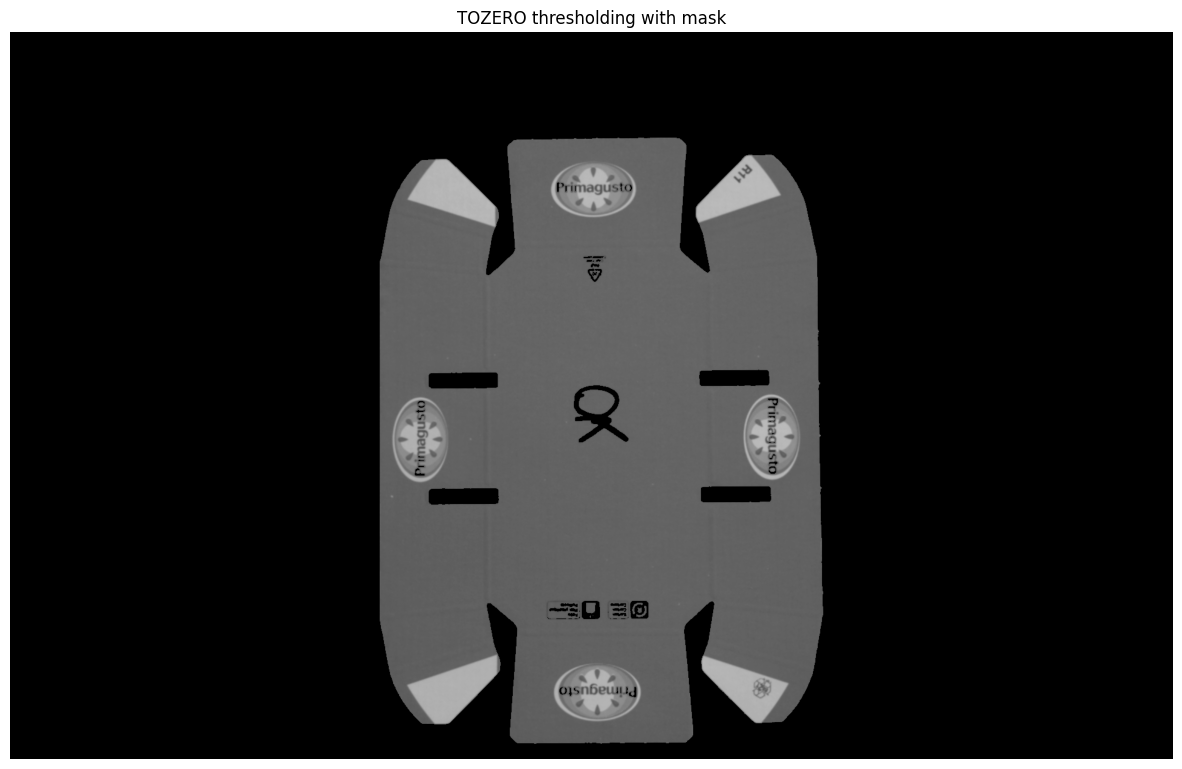

In [92]:
# We create a mask of the same size as the original image
mask = np.zeros_like(udst_crop_img, dtype=np.uint8)

# Inside the hull, we fill the mask with white
cv.fillPoly(mask, [hull_offset], 255)

# We apply the thresholding to the original image
thValue = 80
_, thTOZERO_full = cv.threshold(udst_crop_img, thValue, 255, cv.THRESH_TOZERO)

# Finally, we apply the mask to the thresholded image (we only take care of the area inside the hull)
thTOZERO_masked = cv.bitwise_and(thTOZERO_full, thTOZERO_full, mask=mask)

# The result is shown
plt.figure(figsize=(15, 10))
plt.imshow(thTOZERO_masked, cmap="gray", vmin=0, vmax=255)
plt.title("TOZERO thresholding with mask")
plt.axis("off")
plt.show()

Punto más arriba: (np.int64(1108), np.int64(176))
Punto más abajo: (np.int64(1119), np.int64(1176))
Punto más a la izquierda: (np.int64(611), np.int64(983))
Punto más a la derecha: (np.int64(1344), np.int64(906))


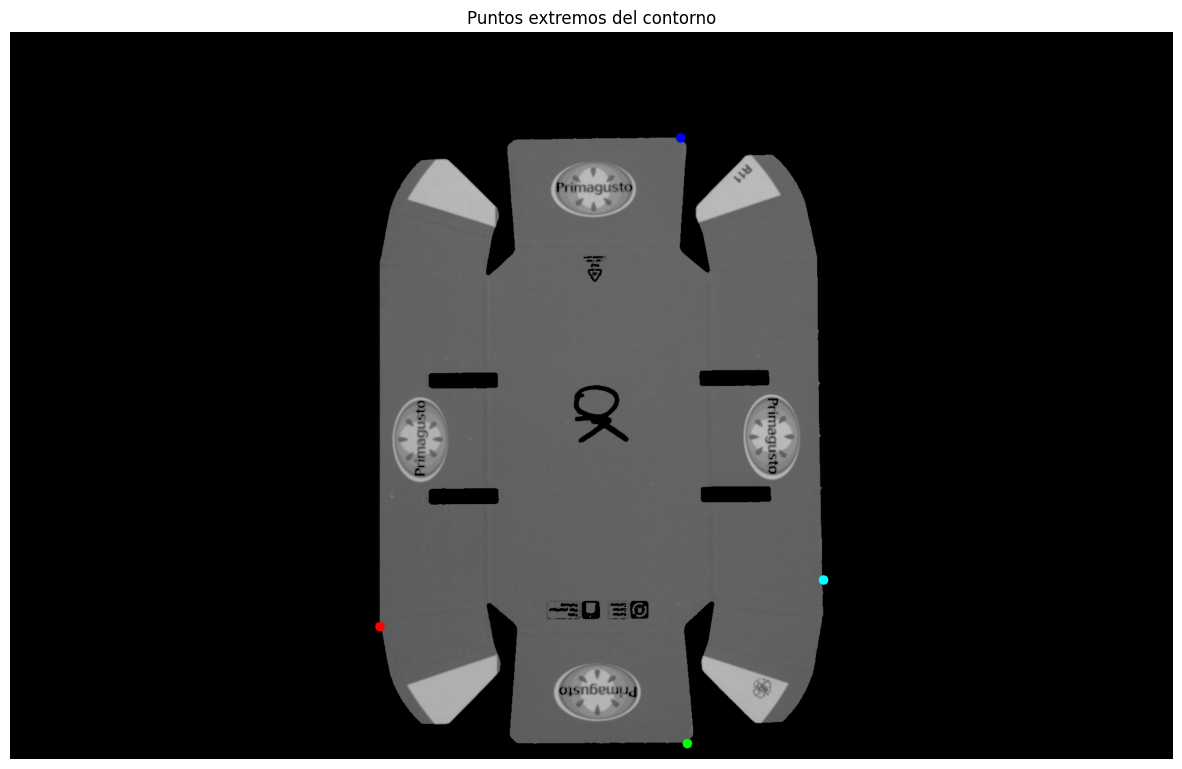

In [93]:
# Encuentra los puntos extremos
topmost    = tuple(hull_offset[hull_offset[:,:,1].argmin()][0])
bottommost = tuple(hull_offset[hull_offset[:,:,1].argmax()][0])
leftmost   = tuple(hull_offset[hull_offset[:,:,0].argmin()][0])
rightmost  = tuple(hull_offset[hull_offset[:,:,0].argmax()][0])

print("Punto más arriba:", topmost)
print("Punto más abajo:", bottommost)
print("Punto más a la izquierda:", leftmost)
print("Punto más a la derecha:", rightmost)


# Copiamos la imagen original para dibujar los puntos
th_COPy_COLOR = cv.cvtColor(thTOZERO_masked, cv.COLOR_GRAY2BGR)

# Opcional: dibuja los puntos en la imagen
for pt, color in zip([topmost, bottommost, leftmost, rightmost], [(255,0,0),(0,255,0),(0,0,255),(255,255,0)]):
    cv.circle(th_COPy_COLOR, pt, 8, color, -1)

plt.figure(figsize=(15,10))
plt.title("Puntos extremos del contorno")
plt.imshow(cv.cvtColor(th_COPy_COLOR, cv.COLOR_BGR2RGB))
plt.axis("off")
plt.show()

height:  1000.0604981699857
width:  737.0332421268392
Cardboard center:  (np.int64(977), np.int64(676))


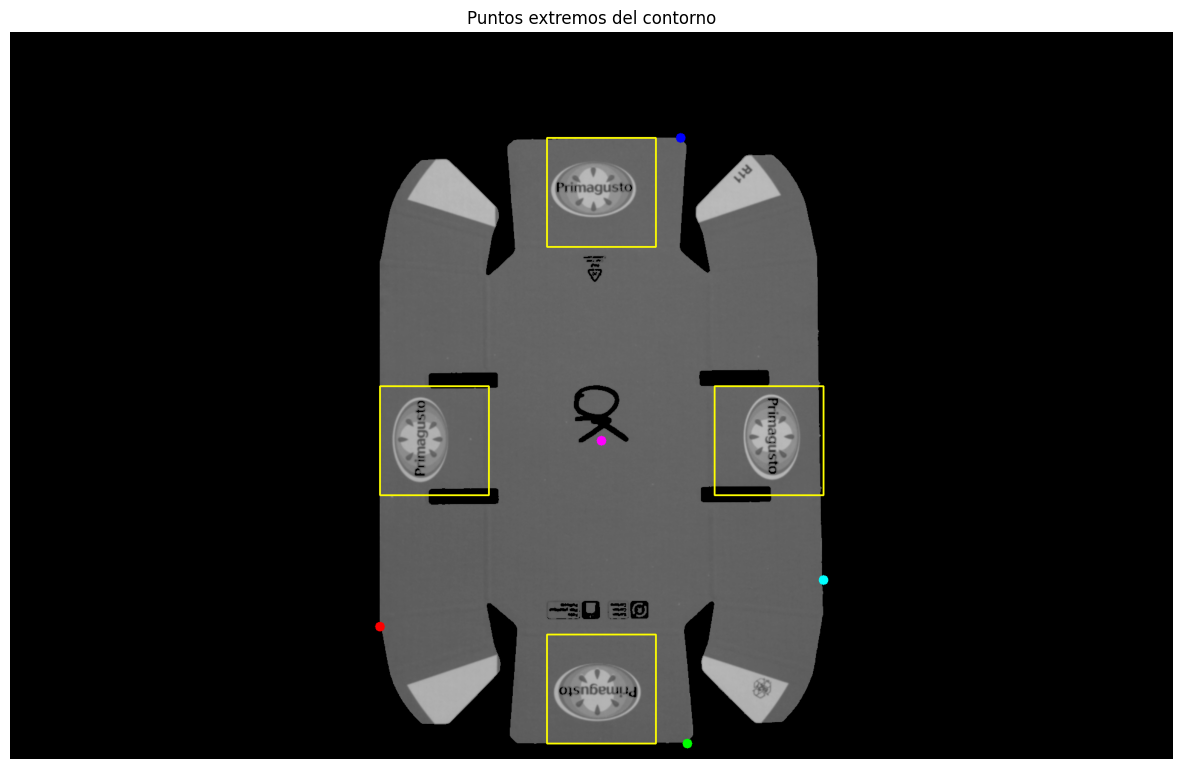

In [ ]:
# Cardboard dimensions approximated
height = np.linalg.norm(np.array(topmost) - np.array(bottommost))
width = np.linalg.norm(np.array(leftmost) - np.array(rightmost))

print("height: ", height)
print("width: ", width)

# We are going to create 4 rectangles in the middle of each coordinate
# PARAMETER TO BE TUNED
rect_h = 180
rect_w = 180

# We find the center of the cardboard
cardboardCenter = tuple([(leftmost[0] + rightmost[0])//2, (topmost[1] + bottommost[1])//2])
print("Cardboard center: ", cardboardCenter)

# We draw the rectangles (using the left corner of the rectangle)
rectangles = [
    (leftmost[0], cardboardCenter[1] + rect_h//2, rect_w, rect_h),
    (rightmost[0] - rect_w, cardboardCenter[1] + rect_h//2, rect_w, rect_h)
    (cardboardCenter[0] - rect_w//2, topmost[1] + rect_h, rect_h, rect_w),
    (cardboardCenter[0] - rect_w//2, bottommost[1], rect_h, rect_w)
]

# We draw the rectangles in the image
for (x, y, w, h) in rectangles:
    cv.rectangle(th_COPy_COLOR, (x, y), (x + w, y - h), (0, 255, 255), 2)
for (x, y, w, h) in rectangles:
    cv.rectangle(th_COPy_COLOR, (x, y), (x + w, y - h), (0, 255, 255), 2)

cv.circle(th_COPy_COLOR, cardboardCenter, 8, (255,0,255), -1)

plt.figure(figsize=(15,10))
plt.title("Puntos extremos del contorno")
plt.imshow(cv.cvtColor(th_COPy_COLOR, cv.COLOR_BGR2RGB))
plt.axis("off")
plt.show()

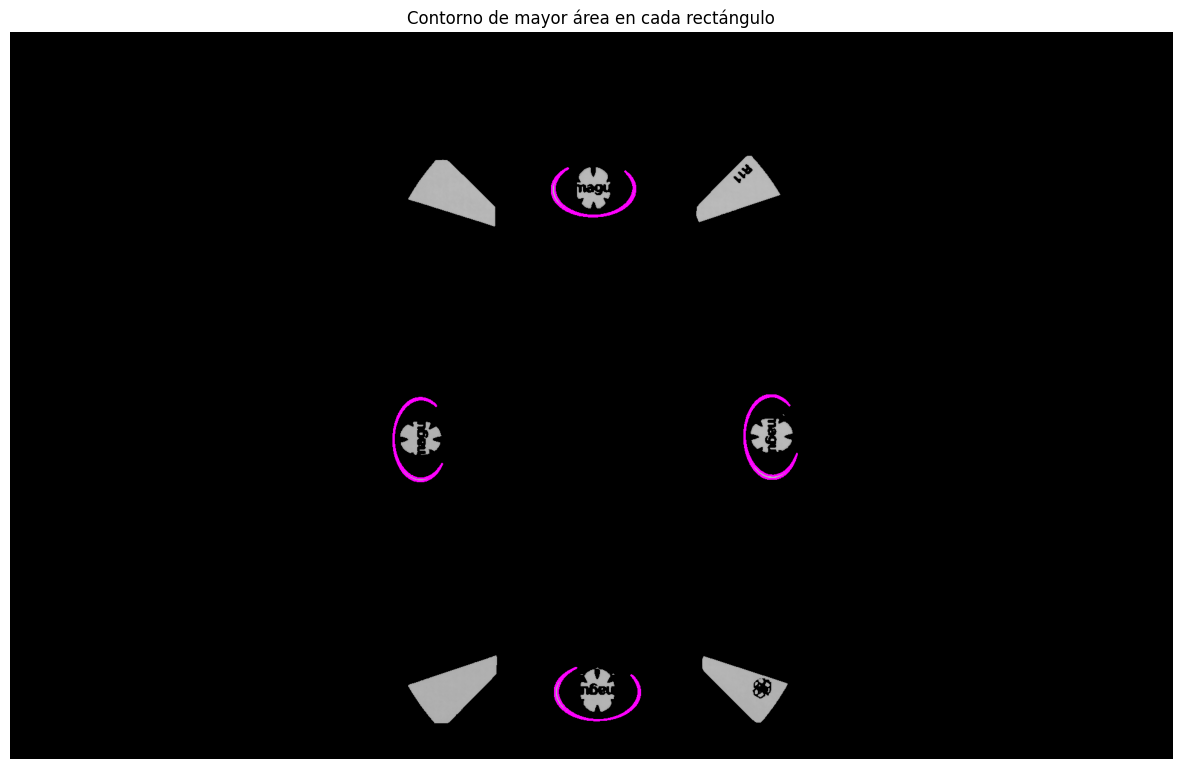

In [105]:
# Copiamos la imagen original para dibujar los puntos
th_Contours_COLOR = cv.cvtColor(thTOZERO_masked, cv.COLOR_GRAY2BGR)

for (x, y, w, h) in rectangles:
    # Recorta la región del rectángulo (cuidado con los límites)
    x1, y1 = max(x, 0), max(y - h, 0)
    x2, y2 = min(x + w, thTOZERO_masked.shape[1]), min(y, thTOZERO_masked.shape[0])
    region = thTOZERO_masked[y1:y2, x1:x2].copy()

    # Encuentra los contornos en la región
    contours, _ = cv.findContours(region, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
    if contours:
        max_contour = max(contours, key=lambda c: cv.arcLength(c, True))
        # Ajusta el contorno a las coordenadas originales de la imagen
        max_contour_shifted = max_contour + np.array([[[x1, y1]]])
        cv.drawContours(th_Contours_COLOR, [max_contour_shifted], -1, (255, 0, 255), 2)
    else:
        print(f"No se encontró contorno en rectángulo ({x1},{y1},{x2},{y2})")

plt.figure(figsize=(15,10))
plt.title("Contorno de mayor área en cada rectángulo")
plt.imshow(cv.cvtColor(th_Contours_COLOR, cv.COLOR_BGR2RGB))
plt.axis("off")
plt.show()

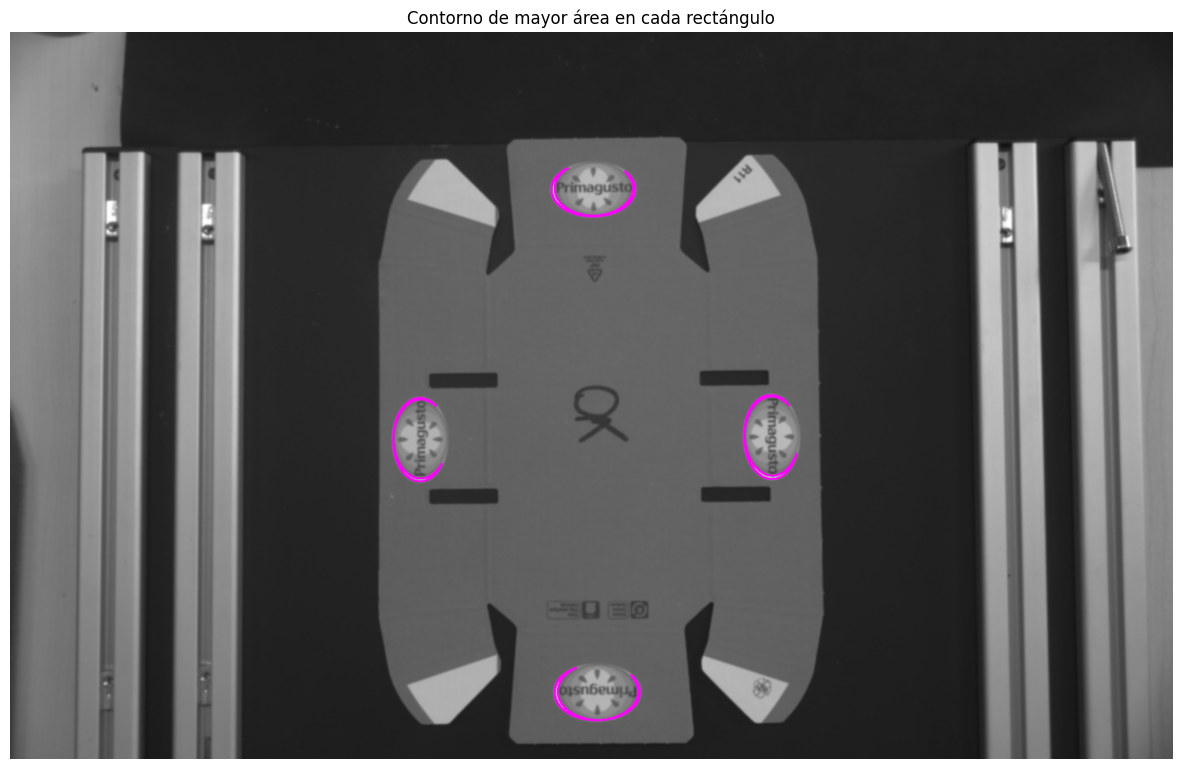

In [107]:
# Copiamos la imagen original para dibujar los puntos
#th_Contours_COLOR = cv.cvtColor(udst_crop_img, cv.COLOR_GRAY2BGR)

th_Contours_COLOR = cv.GaussianBlur(udst_crop_img, (5, 5), 0)

th_Contours_COLOR = cv.cvtColor(th_Contours_COLOR, cv.COLOR_GRAY2BGR)

for (x, y, w, h) in rectangles:
    # Recorta la región del rectángulo (cuidado con los límites)
    x1, y1 = max(x, 0), max(y - h, 0)
    x2, y2 = min(x + w, thTOZERO_masked.shape[1]), min(y, thTOZERO_masked.shape[0])
    region = thTOZERO_masked[y1:y2, x1:x2].copy()

    # Encuentra los contornos en la región
    contours, _ = cv.findContours(region, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
    if contours:
        max_contour = max(contours, key=lambda c: cv.arcLength(c, True))
        # Ajusta el contorno a las coordenadas originales de la imagen
        max_contour_shifted = max_contour + np.array([[[x1, y1]]])
        cv.drawContours(th_Contours_COLOR, [max_contour_shifted], -1, (255, 0, 255), 2)
    else:
        print(f"No se encontró contorno en rectángulo ({x1},{y1},{x2},{y2})")

plt.figure(figsize=(15,10))
plt.title("Contorno de mayor área en cada rectángulo")
plt.imshow(cv.cvtColor(th_Contours_COLOR, cv.COLOR_BGR2RGB))
plt.axis("off")
plt.show()

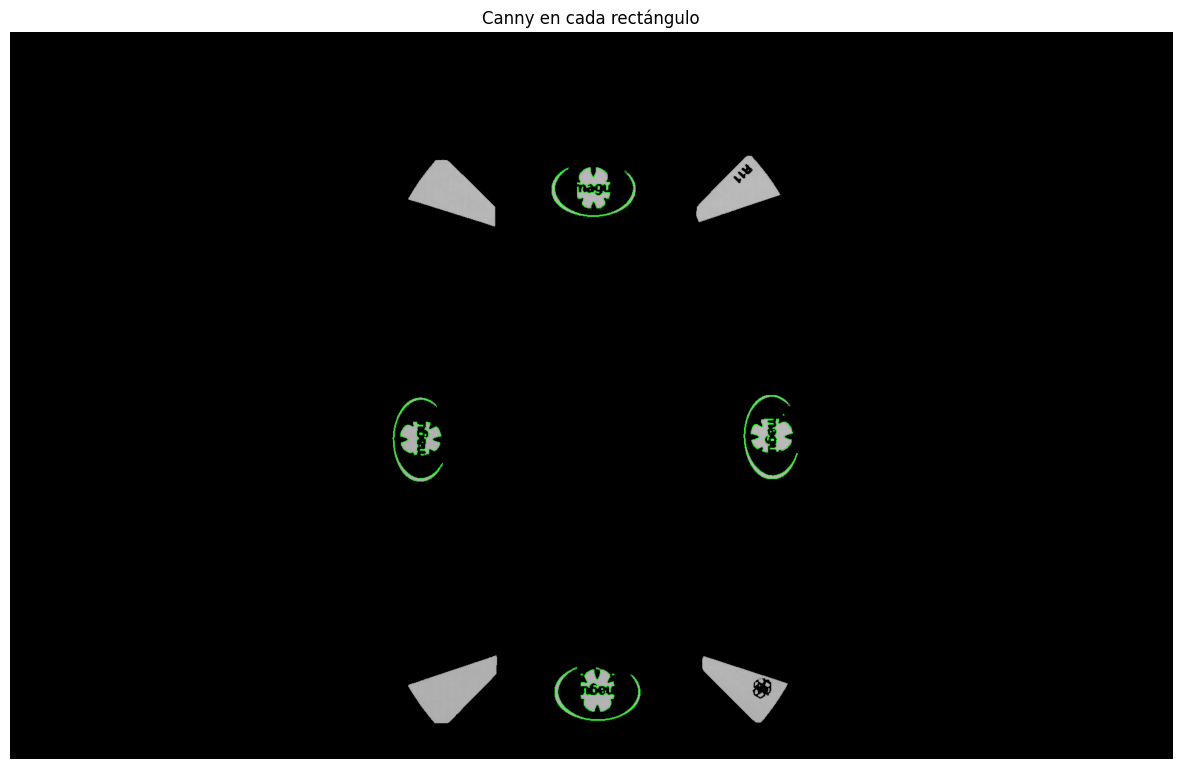

In [102]:
# Copiamos la imagen original para dibujar los bordes
th_Contours_COLOR = cv.cvtColor(thTOZERO_masked, cv.COLOR_GRAY2BGR)

for (x, y, w, h) in rectangles:
    # Recorta la región del rectángulo (cuidado con los límites)
    x1, y1 = max(x, 0), max(y - h, 0)
    x2, y2 = min(x + w, thTOZERO_masked.shape[1]), min(y, thTOZERO_masked.shape[0])
    region = thTOZERO_masked[y1:y2, x1:x2].copy()

    # Aplica Canny en la región
    edges = cv.Canny(region, 40, 130, L2gradient=True)

    # Superpone los bordes en la imagen de color
    mask_edges = edges > 0
    th_Contours_COLOR[y1:y2, x1:x2][mask_edges] = [0, 255, 0]  # Verde

plt.figure(figsize=(15,10))
plt.title("Canny en cada rectángulo")
plt.imshow(cv.cvtColor(th_Contours_COLOR, cv.COLOR_BGR2RGB))
plt.axis("off")
plt.show()

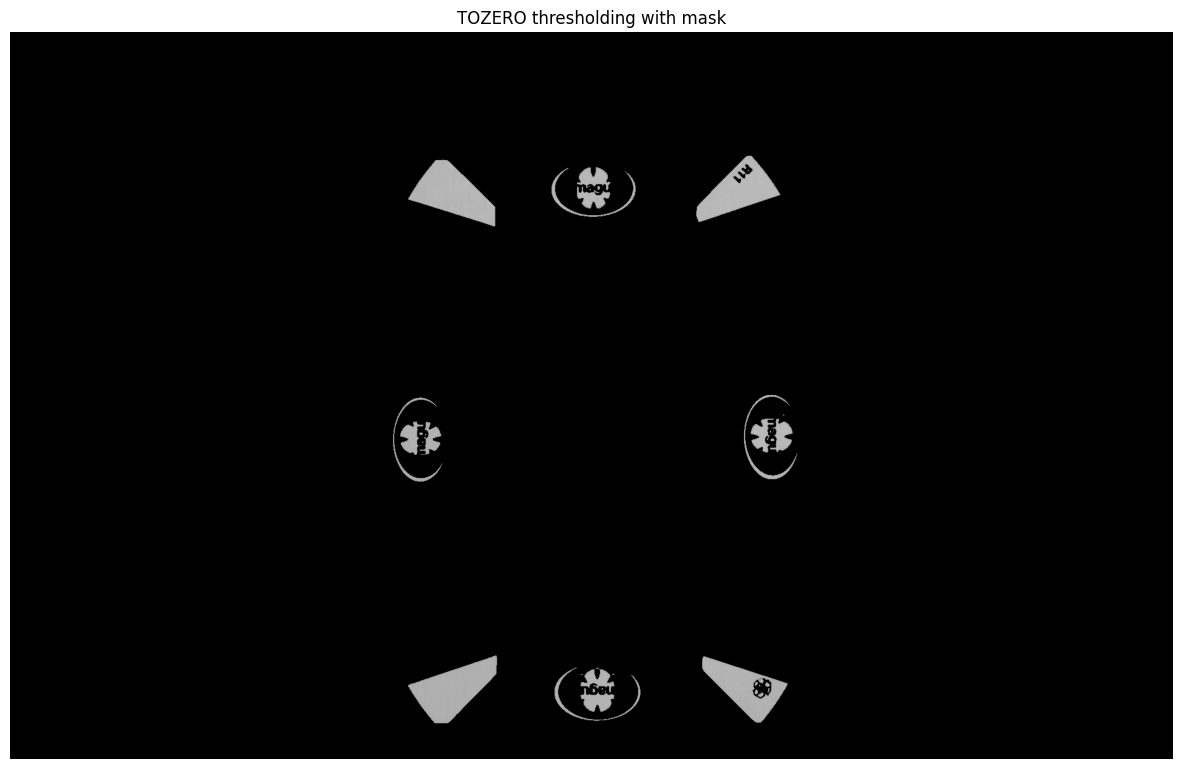

In [95]:
# We create a mask of the same size as the original image
mask = np.zeros_like(udst_crop_img, dtype=np.uint8)

# Inside the hull, we fill the mask with white
cv.fillPoly(mask, [hull_offset], 255)

# We apply the thresholding to the original image
thValue = 150
_, thTOZERO_full = cv.threshold(udst_crop_img, thValue, 255, cv.THRESH_TOZERO)

# Finally, we apply the mask to the thresholded image (we only take care of the area inside the hull)
thTOZERO_masked = cv.bitwise_and(thTOZERO_full, thTOZERO_full, mask=mask)

# The result is shown
plt.figure(figsize=(15, 10))
plt.imshow(thTOZERO_masked, cmap="gray", vmin=0, vmax=255)
plt.title("TOZERO thresholding with mask")
plt.axis("off")
plt.show()

In [96]:
print(thTOZERO_masked.shape)

(1202, 1922)


In [97]:
# Mejorar detección con desenfoque
#blurred = thTOZERO_masked.copy()#cv.medianBlur(contour_img, 5)
#blurred_gray = cv.cvtColor(blurred, cv.COLOR_BGR2GRAY)
blurred_gray = thTOZERO_masked.copy()#cv.medianBlur(contour_img, 5)

# Detección de círculos con HoughCircles
circles = cv.HoughCircles(
    blurred_gray,
    cv.HOUGH_GRADIENT,
    dp=1.2,
    minDist=800,
    param1=100,
    param2=30,
    minRadius=30,
    maxRadius=100
)

if circles is not None:
    circles = np.round(circles[0, :]).astype("int")

    for (x, y, r) in circles:
        # Dibujar el contorno del círculo
        cv.circle(img, (x, y), r, (0, 255, 0), 2)
        # Dibujar el centro del círculo
        cv.circle(img, (x, y), 2, (0, 0, 255), 3)
        print(f"Centro detectado: x={x}, y={y}, radio={r}")

    # Mostrar la imagen con círculos detectados
    cv.imshow("Círculos detectados", img)
    cv.waitKey(10000)
    cv.destroyAllWindows()

else:
    print("No se detectaron círculos.")

Centro detectado: x=713, y=673, radio=80


In [98]:
h, w = thTOZERO_masked.shape
regions = {
    "superior": thTOZERO_masked[0:h//3, :],
    "inferior": thTOZERO_masked[2*h//3:, :],
    "izquierda": thTOZERO_masked[:, 0:w//3],
    "derecha": thTOZERO_masked[:, 2*w//3:]
}

for nombre, region in regions.items():
    circles = cv.HoughCircles(
        region,
        cv.HOUGH_GRADIENT,
        dp=1.2,
        minDist=500,
        param1=100,
        param2=20,  # Puedes ajustar este parámetro
        minRadius=20,
        maxRadius=80
    )
    if circles is not None:
        circles = np.round(circles[0, :]).astype("int")
        for (x, y, r) in circles:
            # Ajustar coordenadas al recorte
            if nombre == "superior":
                y_offset, x_offset = 0, 0
            elif nombre == "inferior":
                y_offset, x_offset = 2*h//3, 0
            elif nombre == "izquierda":
                y_offset, x_offset = 0, 0
            elif nombre == "derecha":
                y_offset, x_offset = 0, 2*w//3
            # Dibujar en la imagen original
            cv.circle(img_circle, (x + x_offset, y + y_offset), r, (0, 255, 0), 2)
            cv.circle(img_circle, (x + x_offset, y + y_offset), 2, (0, 0, 255), 3)
            print(f"Círculo detectado en {nombre}: x={x + x_offset}, y={y + y_offset}, radio={r}")
    else:
        print(f"No se detectaron círculos en la zona {nombre}")

img_cricle_sjown = cv.resize(img_circle, (800, 600))
cv.imshow("Círculos detectados por zonas", img_cricle_sjown)
cv.waitKey(10000)
cv.destroyAllWindows()

Círculo detectado en superior: x=964, y=232, radio=74
Círculo detectado en inferior: x=971, y=1062, radio=77
No se detectaron círculos en la zona izquierda
No se detectaron círculos en la zona derecha


In [99]:
# ...existing code...

h, w = thTOZERO_masked.shape
regions = {
    "superior": (0, 0, h//3, w),
    "inferior": (2*h//3, 0, h, w),
    "izquierda": (0, 0, h, w//3),
    "derecha": (0, 2*w//3, h, w)
}

for nombre, (y1, x1, y2, x2) in regions.items():
    region = thTOZERO_masked[y1:y2, x1:x2]
    # Encuentra contornos en la región
    contours, _ = cv.findContours(region, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
    found = False
    for cnt in contours:
        if len(cnt) >= 5:  # fitEllipse requiere al menos 5 puntos
            ellipse = cv.fitEllipse(cnt)
            (xc, yc), (d1, d2), angle = ellipse
            # Dibuja la elipse en la imagen original (ajustando el offset)
            center = (int(xc + x1), int(yc + y1))
            axes = (int(d1/2), int(d2/2))
            cv.ellipse(img_circle, center, axes, angle, 0, 360, (0,255,0), 2)
            cv.circle(img_circle, center, 2, (0,0,255), 3)
            print(f"Elipse detectada en {nombre}: centro={center}, ejes={axes}, ángulo={angle:.1f}")
            found = True
            break  # Solo una elipse por zona
    if not found:
        print(f"No se detectó elipse en la zona {nombre}")

img_cricle_sjown = cv.resize(img_circle, (800, 600))
cv.imshow("Elipses detectadas por zonas", img_cricle_sjown)
cv.waitKey(10000)
cv.destroyAllWindows()

Elipse detectada en superior: centro=(963, 275), ejes=(15, 26), ángulo=101.5
Elipse detectada en inferior: centro=(963, 1088), ejes=(2, 2), ángulo=169.2
Elipse detectada en izquierda: centro=(652, 672), ejes=(18, 47), ángulo=1.0
Elipse detectada en derecha: centro=(1293, 1070), ejes=(4, 12), ángulo=0.0


In [100]:
print(contour_img.shape)

(1202, 1922, 3)
